In [1]:
import findspark
findspark.init()


In [2]:
import pyspark
sc=pyspark.SparkContext(appName="pi")

In [3]:
sc.master

'local[*]'

In [4]:
global Path
Path="/home/user/Desktop/Project/"

In [5]:
print("開始匯入資料...")
rawDataWithHeader = sc.textFile(Path+"train.tsv")
rawDataWithHeader.take(2)

開始匯入資料...


['\turlid\tboilerplate\talchemy_category\talchemy_category_score\tavglinksize\tcommonlinkratio_1\tcommonlinkratio_2\tcommonlinkratio_3\tcommonlinkratio_4\tcompression_ratio\tembed_ratio\tframebased\tframeTagRatio\thasDomainLink\thtml_ratio\timage_ratio\tis_news\tlengthyLinkDomain\tlinkwordscore\tnews_front_page\tnon_markup_alphanum_characters\tnumberOfLinks\tnumwords_in_url\tparametrizedLinkRatio\tspelling_errors_ratio\tlabel',
 'http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html\t4042\t"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose California Photographer Tony Av

In [6]:
print("開始匯入資料...")
rawDataWithHeader = sc.textFile(Path+"train.tsv")
header = rawDataWithHeader.first()
rawData = rawDataWithHeader.filter(lambda x:x !=header)
rData = rawData.map(lambda x:x.replace("\"",""))
lines = rData.map(lambda x:x.split("\t"))
print("total:"+str(lines.count()))

開始匯入資料...
total:7395


In [7]:
lines.first()[3:]

['business',
 '0.789131',
 '2.055555556',
 '0.676470588',
 '0.205882353',
 '0.047058824',
 '0.023529412',
 '0.443783175',
 '0',
 '0',
 '0.09077381',
 '0',
 '0.245831182',
 '0.003883495',
 '1',
 '1',
 '24',
 '0',
 '5424',
 '170',
 '8',
 '0.152941176',
 '0.079129575',
 '0']

In [8]:
categoriesMap =lines.map(lambda fields: fields[3]) \
        .distinct().zipWithIndex().collectAsMap()
categoriesMap

{'?': 2,
 'arts_entertainment': 3,
 'business': 0,
 'computer_internet': 6,
 'culture_politics': 5,
 'gaming': 4,
 'health': 12,
 'law_crime': 7,
 'recreation': 11,
 'religion': 8,
 'science_technology': 13,
 'sports': 1,
 'unknown': 10,
 'weather': 9}

In [9]:
import numpy as np
def extract_features(field,categoriesMap,featureEnd):
    #擷取分類特徵欄位
    categoryIdx = categoriesMap[field[3]] 
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    #擷取數值欄位
    numericalFeatures=[convert_float(field)  for  field in field[4: featureEnd]]    
    #回傳「分類特徵欄位」+「數字特徵欄位」
    return  np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=="?" else float(x))

In [10]:
def extract_label(field):
    label=(field[-1])
    return float(label)

In [11]:
labelRDD = lines.map( lambda r: extract_label(r))
print(labelRDD.take(1))

[0.0]


In [12]:
from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map( lambda r: 
     LabeledPoint(
                extract_label(r),
                extract_features(r,categoriesMap,len(r) - 1)))

In [13]:
print(lines.first()[3:])

['business', '0.789131', '2.055555556', '0.676470588', '0.205882353', '0.047058824', '0.023529412', '0.443783175', '0', '0', '0.09077381', '0', '0.245831182', '0.003883495', '1', '1', '24', '0', '5424', '170', '8', '0.152941176', '0.079129575', '0']


In [14]:
labelpointRDD.take(1)

[LabeledPoint(0.0, [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789131,2.055555556,0.676470588,0.205882353,0.047058824,0.023529412,0.443783175,0.0,0.0,0.09077381,0.0,0.245831182,0.003883495,1.0,1.0,24.0,0.0,5424.0,170.0,8.0,0.152941176,0.079129575])]

In [15]:
(trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
print("將資料分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))

將資料分trainData:5897   validationData:743   testData:755


In [43]:
def PrepareData(sc):
    #import data & translation
    Path="/home/user/Desktop/Project/"
    
    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile(Path+"train.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共計：" + str(lines.count()) + "筆")
    #----------2.建立訓練評估所需資料 RDD[LabeledPoint]-------    
    categoriesMap = lines.map(lambda fields: fields[3]).\
                                   distinct().zipWithIndex().collectAsMap()
    labelpointRDD = lines.map( lambda r:
               LabeledPoint(
                      extract_label(r), 
                      extract_features(r,categoriesMap,-1)))
    
    labelpointRDDFeaturesInfo = lines.map( lambda r:LabeledPoint(
                 extract_label(r), 
                 extract_features_FeaturesInfo(r,categoriesMap,len(r) - 1)))
        
    #-----------3.以隨機方式將資料分為3部份並且回傳-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("將資料分trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData, categoriesMap) #回傳資料

In [47]:
(trainData, validationData, testData, categoriesMap) =PrepareData(sc)

開始匯入資料...
共計：7395筆
將資料分trainData:5947   validationData:735   testData:713


In [48]:
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[122] at RDD at PythonRDD.scala:48

In [50]:
from pyspark.mllib.tree import DecisionTree
model = DecisionTree.trainClassifier(trainData, numClasses=2,categoricalFeaturesInfo={},
                                    impurity="entropy", maxDepth=5,maxBins=5)

# Prediction

In [51]:
def PredictData(sc,model, categoriesMap):
    print("import data~")
    rawDataWithHeader = sc.textFile(Path+"test.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共計：" + str(lines.count()) + "筆")
    dataRDD = lines.map(lambda r:  ( r[0]  ,
                            extract_features(r,categoriesMap,len(r) )))
    DescDict = {
            0: "暫時性網頁(ephemeral)",
           1: "長青網頁(evergreen)"
    }
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        print("address : "+str(data[0])+"\n"+"prediction : "+str(predictResult)+ "說明:"+DescDict[predictResult] +"\n")
        

In [52]:
print("-------預測資料------")
PredictData(sc,model,categoriesMap)

-------預測資料------
import data~
共計：3171筆
address : http://www.lynnskitchenadventures.com/2009/04/homemade-enchilada-sauce.html
prediction : 1.0說明:長青網頁(evergreen)

address : http://lolpics.se/18552-stun-grenade-ar
prediction : 0.0說明:暫時性網頁(ephemeral)

address : http://www.xcelerationfitness.com/treadmills.html
prediction : 0.0說明:暫時性網頁(ephemeral)

address : http://www.bloomberg.com/news/2012-02-06/syria-s-assad-deploys-tactics-of-father-to-crush-revolt-threatening-reign.html
prediction : 0.0說明:暫時性網頁(ephemeral)

address : http://www.wired.com/gadgetlab/2011/12/stem-turns-lemons-and-limes-into-juicy-atomizers/
prediction : 0.0說明:暫時性網頁(ephemeral)

address : http://www.latimes.com/health/boostershots/la-heb-fat-tax-denmark-20111013,0,2603132.story
prediction : 0.0說明:暫時性網頁(ephemeral)

address : http://www.howlifeworks.com/a/a?AG_ID=1186&cid=7340ci
prediction : 1.0說明:長青網頁(evergreen)

address : http://romancingthestoveblog.wordpress.com/2010/01/13/sweet-potato-ravioli-with-lemon-sage-brown-butter

# Evaluation

In [60]:
score = model.predict(validationData.map(lambda p:p.features))
scoreAndLabels=score .zip(validationData.map(lambda p: p.label))
scoreAndLabels.take(5)

[(1.0, 0.0), (0.0, 0.0), (1.0, 1.0), (1.0, 0.0), (0.0, 0.0)]

In [62]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(scoreAndLabels)
print("AUC="+str(metrics.areaUnderROC))

AUC=0.6426610419177716


In [63]:
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)

In [65]:
AUC=evaluateModel(model, validationData)
print("AUC="+str(AUC))

AUC=0.6426610419177716


In [67]:
from time import time
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print("訓練評估：使用參數" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需時間="+str(duration) + \
                 " 結果AUC = " + str(AUC))
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

In [68]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=0.6958346366882324 結果AUC = 0.6426610419177716


In [69]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=0.8175287246704102 結果AUC = 0.6452243786497931


In [95]:
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10 ]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=0.6326093673706055 結果AUC = 0.6698361680282131
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=0.6002984046936035 結果AUC = 0.6677268871925361


In [96]:
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.669836,0.632609,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.667727,0.600298,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


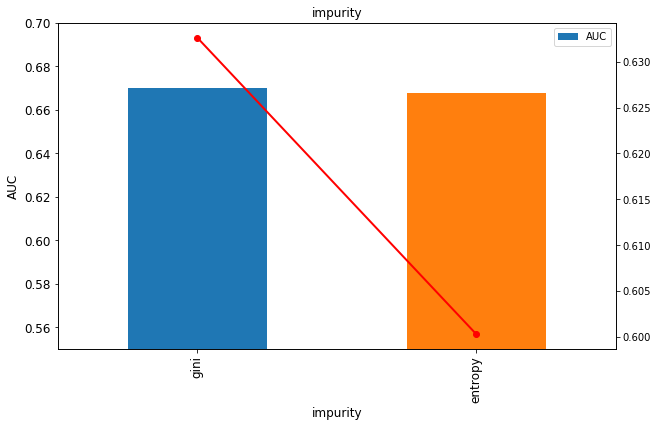

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline 
evalparm='impurity'
ax = df['AUC'].plot(kind='bar', title =evalparm,figsize=(10,6),
                legend=True, fontsize=12)
ax.set_xlabel(evalparm,fontsize=12)
ax.set_ylim([0.55,0.7])
ax.set_ylabel("AUC",fontsize=12)
ax2 = ax.twinx()
ax2.plot(df['duration'].values, linestyle='-', marker='o', linewidth=2.0,color='r')
plt.show()

In [98]:
#定義evalParameter函數
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #訓練評估參數
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #設定目前評估的參數
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #轉換為Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #顯示圖形
    showchart(df,evalparm,'AUC','duration',0.5,0.7 )

訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.467210054397583 結果AUC = 0.6121490112048568
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.5820939540863037 結果AUC = 0.6349046917548324
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=0.6313049793243408 結果AUC = 0.6698361680282131
訓練評估：使用參數 impurity=gini maxDepth=15 maxBins=10
 ==>所需時間=0.6745707988739014 結果AUC = 0.6401388330878086
訓練評估：使用參數 impurity=gini maxDepth=20 maxBins=10
 ==>所需時間=0.8847367763519287 結果AUC = 0.6264117673318156
訓練評估：使用參數 impurity=gini maxDepth=25 maxBins=10
 ==>所需時間=0.9160552024841309 結果AUC = 0.6291460202669524


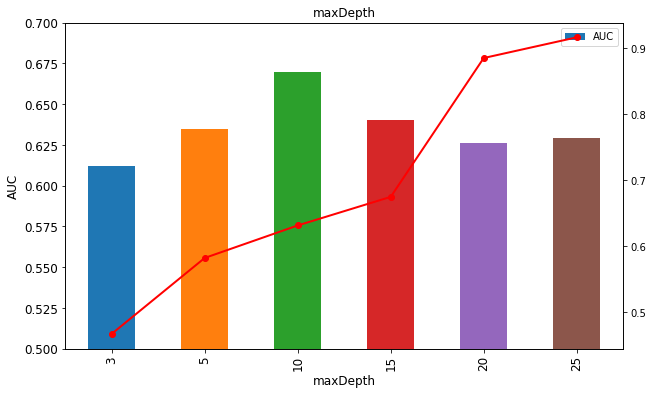

In [99]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])   

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=3
 ==>所需時間=0.5687780380249023 結果AUC = 0.642326235435918
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=5
 ==>所需時間=0.6643438339233398 結果AUC = 0.6522365072987812
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=0.6176261901855469 結果AUC = 0.6698361680282131
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=50
 ==>所需時間=0.5637078285217285 結果AUC = 0.6636087674657382
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=100
 ==>所需時間=0.7217555046081543 結果AUC = 0.6533748493370832
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=200
 ==>所需時間=0.8136518001556396 結果AUC = 0.6394580599080398


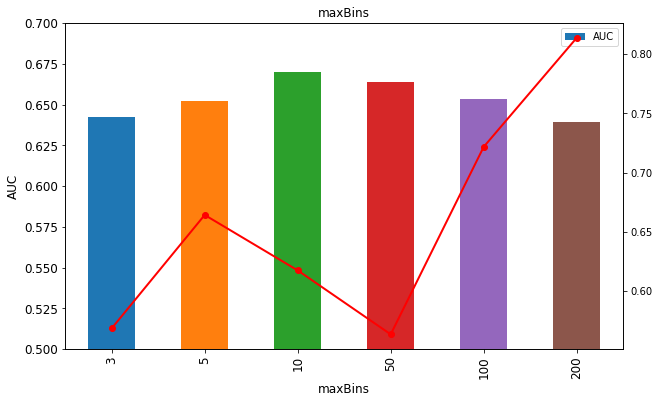

In [100]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

In [101]:
#定義evalAllParameter函數
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for迴圈訓練評估所有參數組合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的參數組合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #顯示調校後最佳參數組合      
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    結果AUC = " + str(bestParameter[0]))
    #傳回最佳模型
    return bestParameter[5]

In [103]:
print("-----所有參數訓練評估找出最好的參數組合---------")  
bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15, 20, 25], 
                          [3, 5, 10, 50, 100, 200 ])

-----所有參數訓練評估找出最好的參數組合---------
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=3
 ==>所需時間=0.46259236335754395 結果AUC = 0.6253738672380698
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=5
 ==>所需時間=0.5595073699951172 結果AUC = 0.6161443685549752
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.492767333984375 結果AUC = 0.6121490112048568
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=50
 ==>所需時間=0.41994190216064453 結果AUC = 0.6113901165126557
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=100
 ==>所需時間=0.38559651374816895 結果AUC = 0.6136333199410742
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=200
 ==>所需時間=0.6666157245635986 結果AUC = 0.6220592830677203
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=3
 ==>所需時間=0.5058708190917969 結果AUC = 0.6236663541806169
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=5
 ==>所需時間=0.41190433502197266 結果AUC = 0.6543792687826436
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.5870463848114014 結果AUC = 0.6349046917548324
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=50
 ==>所需時間=0.4

In [105]:
print(model.toDebugString())

DecisionTreeModel classifier of depth 5 with 63 nodes
  If (feature 31 <= 2735.0)
   If (feature 31 <= 1216.0)
    If (feature 3 <= 0.0)
     If (feature 12 <= 0.0)
      If (feature 23 <= 0.038427167)
       Predict: 0.0
      Else (feature 23 > 0.038427167)
       Predict: 0.0
     Else (feature 12 > 0.0)
      If (feature 20 <= 0.627906977)
       Predict: 1.0
      Else (feature 20 > 0.627906977)
       Predict: 0.0
    Else (feature 3 > 0.0)
     If (feature 34 <= 0.284552846)
      If (feature 29 <= 30.0)
       Predict: 0.0
      Else (feature 29 > 30.0)
       Predict: 0.0
     Else (feature 34 > 0.284552846)
      If (feature 29 <= 47.0)
       Predict: 0.0
      Else (feature 29 > 47.0)
       Predict: 0.0
   Else (feature 31 > 1216.0)
    If (feature 11 <= 0.0)
     If (feature 1 <= 0.0)
      If (feature 3 <= 0.0)
       Predict: 0.0
      Else (feature 3 > 0.0)
       Predict: 0.0
     Else (feature 1 > 0.0)
      If (feature 16 <= 0.299342105)
       Predict: 0.0
      El